In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR, SVC
from sklearn.metrics import r2_score, balanced_accuracy_score, accuracy_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [3]:
def splitFunction(a,b,size):
    newX_Train = pd.DataFrame()
    newY_Train = []
    newX_Test = pd.DataFrame()
    newY_Test = []
    for i in b.value_counts().index:
        x_train, x_test, y_train, y_test = train_test_split(a[b==i], b[b==i], test_size=size)
        newX_Train = newX_Train.append(x_train)
        newX_Test = newX_Test.append(x_test)
        newY_Train.extend(y_train.tolist())
        newY_Test.extend(y_test.tolist())
    return(newX_Train,newX_Test,newY_Train,newY_Test)

In [33]:
inFile = "/Users/saurabhgulati/v2DataAnalysis/mergedFiles/purple/everythingMerged.tsv"

df = pd.read_csv(inFile,sep="\t",index_col=0)

renamer = {'fwd_GC_perc':'fwd_GC',
'rev_GC_perc':'rev_GC',
'amplicon_len':'amplicon_length',
'fwd_length':'fwd_len',
'rev_length':'rev_len',
'fwd_primer_maxN':'fwd_maxN',
'rev_primer_maxN':'rev_maxN',
'amp_GC':'ampliconGC'}
    

df = df.rename(index=str,columns=renamer)

y = df['NormalizedMean']
# x = df[['fwd_GC','fwd_Tm','rev_GC',
#  'rev_Tm','amplicon_length','fwd_len','rev_len','ampliconGC',
#       'fwd_num_hits_no_mismatch_in_last5','rev_num_hits_no_mismatch_in_last5']]

x = df.drop(columns=['NormalizedMean'])
# list(x)

yC = y.copy().astype(str)
x2 = pd.DataFrame()
y2 = []
ySmall = []

for i in range(len(y)):
    if y[i] < 0.2:
        yC[i] = 'low'
        x2 = x2.append(x.iloc[i])
        y2.append(yC[i])
        ySmall.append(y[i])
    elif y[i] >= 0.2 and y[i] <=2:
        yC[i] = 'ok'
        x2 = x2.append(x.iloc[i])
        y2.append(yC[i])
        ySmall.append(y[i])
    else:
        yC[i] = 'high'

y2 = pd.Series(data=y2,index=x2.index) 
ySmall = pd.Series(data=ySmall)
yCmasked = yC.copy()
yCmasked[yC == "high"] = "low"

In [34]:
model1 = LinearRegression()
model2 = SVR(kernel='rbf')
model3 = KNeighborsRegressor(weights='distance',algorithm='brute')
x_train, x_test, y_train, y_test = train_test_split(x2, ySmall, test_size=0.3)
model1.fit(x_train,y_train)
model2.fit(x_train,y_train)
model3.fit(x_train,y_train)
print("Linear Regression",round(r2_score(y_test,model1.predict(x_test)),3))
print("Support Vector Regressor",round(r2_score(y_test,model2.predict(x_test)),3))
print("K Neighbors Regressor",round(r2_score(y_test,model3.predict(x_test)),3))

/Users/saurabhgulati/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Linear Regression 0.228
Support Vector Regressor 0.668
K Neighbors Regressor 0.666


In [35]:
accuracies1 = []
accuracies2 = []
accuracies3 = []
properties = [x,x,x2]
classes = [yC,yCmasked,y2]
dataType = ['Original Data', 'Masked Data', 'Reduced Data']

for j in range(len(properties)):
    temp1 = []
    temp2 = []
    temp3 = []
    for i in range(1000):
        x_train, x_test, y_train, y_test = splitFunction(properties[j], classes[j],0.3)
        model1 = KNeighborsClassifier(weights='distance',algorithm='brute')
        model1.fit(x_train,y_train)
        temp1.append(balanced_accuracy_score(y_test,model1.predict(x_test)))
        model2 = SVC(kernel='rbf',gamma='auto')
        model2.fit(x_train,y_train)
        temp2.append(balanced_accuracy_score(y_test,model2.predict(x_test)))
        model3 = RandomForestClassifier(max_depth=6, random_state=42, n_estimators=100)
        model3.fit(x_train,y_train)
        temp3.append(balanced_accuracy_score(y_test,model3.predict(x_test)))

#     print(dataType[j],"Median accuracy, KNC",np.median(temp1))
#     print(dataType[j],"Mean accuracy, KNC",np.mean(temp1))
#     print(dataType[j],"Median accuracy, SVC",np.median(temp2))
#     print(dataType[j],"Mean accuracy, SVC",np.mean(temp2))
    accuracies1.append(temp1)
    accuracies2.append(temp2)
    accuracies3.append(temp3)

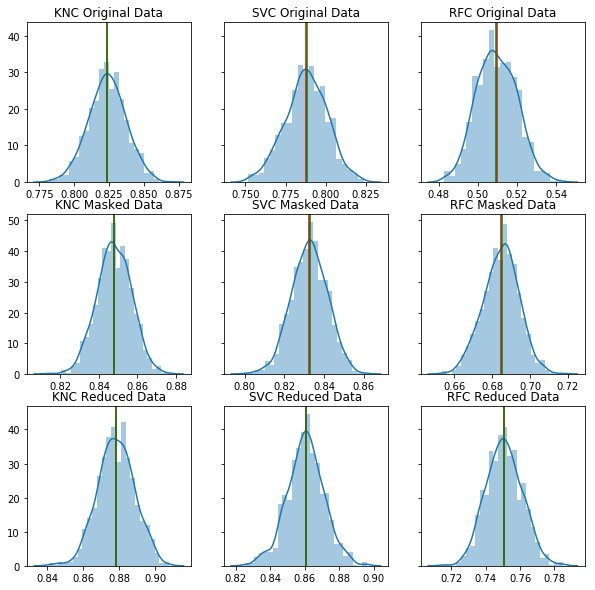

In [36]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharey='row')
sns.distplot(accuracies1[0],ax = axs[0][0]).set_title('KNC Original Data')
axs[0][0].axvline(np.mean(accuracies1[0]),color='red')
axs[0][0].axvline(np.median(accuracies1[0]),color='green')
sns.distplot(accuracies2[0],ax = axs[0][1]).set_title('SVC Original Data')
axs[0][1].axvline(np.mean(accuracies2[0]),color='red')
axs[0][1].axvline(np.median(accuracies2[0]),color='green')
sns.distplot(accuracies3[0],ax = axs[0][2]).set_title('RFC Original Data')
axs[0][2].axvline(np.mean(accuracies3[0]),color='red')
axs[0][2].axvline(np.median(accuracies3[0]),color='green')
sns.distplot(accuracies1[1],ax = axs[1][0]).set_title('KNC Masked Data')
axs[1][0].axvline(np.mean(accuracies1[1]),color='red')
axs[1][0].axvline(np.median(accuracies1[1]),color='green')
sns.distplot(accuracies2[1],ax = axs[1][1]).set_title('SVC Masked Data')
axs[1][1].axvline(np.mean(accuracies2[1]),color='red')
axs[1][1].axvline(np.median(accuracies2[1]),color='green')
sns.distplot(accuracies3[1],ax = axs[1][2]).set_title('RFC Masked Data')
axs[1][2].axvline(np.mean(accuracies3[1]),color='red')
axs[1][2].axvline(np.median(accuracies3[1]),color='green')
sns.distplot(accuracies1[2],ax = axs[2][0]).set_title('KNC Reduced Data')
axs[2][0].axvline(np.mean(accuracies1[2]),color='red')
axs[2][0].axvline(np.median(accuracies1[2]),color='green')
sns.distplot(accuracies2[2],ax = axs[2][1]).set_title('SVC Reduced Data')
axs[2][1].axvline(np.mean(accuracies2[2]),color='red')
axs[2][1].axvline(np.median(accuracies2[2]),color='green')
sns.distplot(accuracies3[2],ax = axs[2][2]).set_title('RFC Reduced Data')
axs[2][2].axvline(np.mean(accuracies3[2]),color='red')
axs[2][2].axvline(np.median(accuracies3[2]),color='green')